In [1]:
import pandas as pd
import numpy as np
import torch
import warnings
import sys, os
import json

sys.path.append(os.path.abspath('..'))

ais_type_labels = '../../data/ais_type_labels.csv'
cleaned_detections_path = '../../data/cleaned_data/preprocessed_radar_detections.csv'
ais_type_labels = pd.read_csv(ais_type_labels)
radar_detections = pd.read_csv(cleaned_detections_path)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

/Users/liuzehan/miniconda3/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Using device: mps


In [8]:
BATCH_SIZE = 32
MAX_LENGTH = 256
HIDDEN_DIM_LSTM = 128
HIDDEN_DIM_LINEAR_1 = 64
HIDDEN_DIM_LINEAR_2 = 32
NUM_LAYERS_LSTM = 1

## Load Data

In [3]:
from dataloader_lstm import load_data

train_loader, val_loader, test_loader = load_data(radar_detections, ais_type_labels, BATCH_SIZE)

-- Summary statistics created from SumStatsBaseline --
-- Summary columns: ['max_speed', 'min_speed', 'avg_speed', 'curviness', 'heading_mean', 'heading_std', 'turning_mean', 'turning_std', 'distance_total', 'distance_o'] --
-- Prepared 14204 track tensors (raw features) on mps --
Data split: 9942 train, 2131 val, 2131 test


In [9]:
import json

with open('model_specs/LSTM_specs.json', 'r') as f:
    specs = json.load(f)

feature_cols = specs['feature_cols']
summary_cols = specs['summary_cols']


## Model Building

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from core.DICT import TYPE_to_LABEL 

class TypeLSTMClassifier(nn.Module):
    
    def __init__(self, hidden_dim_lstm, hidden_dim_linear_1, hidden_dim_linear_2, num_layers, features_cols = feature_cols, summary_cols = summary_cols):
        super().__init__()
        self.input_dim = len(features_cols)
        self.summary_dim = len(summary_cols)
        self.TYPE_to_LABEL = TYPE_to_LABEL
        self.num_classes = len(self.TYPE_to_LABEL)

        self.lstm = nn.LSTM(self.input_dim, hidden_dim_lstm, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim_lstm + self.summary_dim, hidden_dim_linear_1)
        self.fc2 = nn.Linear(hidden_dim_linear_1, hidden_dim_linear_2)
        self.fc3 = nn.Linear(hidden_dim_linear_2, self.num_classes)

    def forward(self, x, lengths, summaries):
        # lengths: shape [B], indicating real length of each sequence
        x_packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hidden, _) = self.lstm(x_packed)  # LSTM returns (output, (hidden, cell))

        last_hidden = hidden[-1]  #B, hidden_dim_lstm
        concat_layer = torch.cat((last_hidden, summaries), dim=1)  # B, hidden_dim_lstm + summary_dim
        fc1 = self.fc1(concat_layer) #B, hidden_dim_linear
        fc1 = F.relu(fc1)
        fc2 = self.fc2(fc1)
        fc2 = F.relu(fc2)
        logits = self.fc3(fc2)

        return logits


In [11]:
EPOCH = 5

from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

model = TypeLSTMClassifier(HIDDEN_DIM_LSTM, HIDDEN_DIM_LINEAR_1, HIDDEN_DIM_LINEAR_2, num_layers = NUM_LAYERS_LSTM).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
scheduler = StepLR(optimizer, step_size=2, gamma=0.5) 

train_losses = []
val_losses = []

for epoch in range(EPOCH):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)

    for x_batch, lengths, summaries, y_batch in progress_bar:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        summaries = summaries.to(device)
        
        optimizer.zero_grad()
        logits = model(x_batch, lengths, summaries) #B * num_classes
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    scheduler.step()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate on validation set
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_val, lengths_val, summaries_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            summaries_val = summaries_val.to(device)
            output_val = model(x_val, lengths_val, summaries_val)
            loss_val = criterion(output_val, y_val)
            val_loss += loss_val.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f" Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

save_path = 'models/lstm_5_epochs.pth'

torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses
}, save_path)


 Epoch 1 | Train Loss: 1.4972 | Val Loss: 1.4794


 Epoch 2 | Train Loss: 1.5431 | Val Loss: 1.5555


 Epoch 3 | Train Loss: 1.5535 | Val Loss: 1.5533


 Epoch 4 | Train Loss: 1.5537 | Val Loss: 1.5523


 Epoch 5 | Train Loss: 1.5536 | Val Loss: 1.5520


In [14]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[ 0.4105,  0.2578, -0.3043,  0.2511],
        [ 0.0041, -0.1156, -0.2112,  0.1242],
        [-0.2978, -0.3144,  0.2661, -0.2440],
        ...,
        [-0.2975, -0.2210,  0.2847, -0.2938],
        [-0.3206,  0.3998, -0.2543,  0.2071],
        [ 0.3835,  0.3414, -0.3041,  0.2683]], device='mps:0',
       requires_grad=True)
Parameter containing:
tensor([[-0.3405, -0.0333,  0.0923,  ...,  0.3532,  0.2143,  0.3028],
        [-0.0373,  0.0744, -0.0357,  ..., -0.0607, -0.0652,  0.0544],
        [ 0.2092, -0.0440,  0.1809,  ...,  0.0687, -0.3182, -0.2546],
        ...,
        [ 0.0452, -0.0541, -0.0219,  ..., -0.3327,  0.0905, -0.2545],
        [-0.0041, -0.0177,  0.0106,  ...,  0.0905, -0.0656,  0.0739],
        [-0.2948,  0.1096, -0.0488,  ...,  0.2439, -0.1159,  0.2603]],
       device='mps:0', requires_grad=True)
Parameter containing:
tensor([ 2.7551e-01, -4.3057e-02, -3.1378e-01,  3.5880e-01, -2.6981e-01,
         1.6201e-01,  1.5384e-01,  7.0627e-02, -2.9

### Resume Training

In [ ]:
##TODO: UPDATE MODEL 

checkpoint = torch.load('models/gru_5_epochs.pth', map_location=device)

# Recreate the model architecture
model = VesselRNNClassifier(
    input_dim=checkpoint['input_dim'],
    hidden_dim=checkpoint['hidden_dim'],
    num_classes=checkpoint['num_classes'],
    num_layers=NUM_LAYERS_LSTM
).to(device)

# Load saved state
model.load_state_dict(checkpoint['model_state_dict'])

# Restore optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)  # same LR as before
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Continue tracking losses
TRAIN_LOSSES = checkpoint['train_losses']
VAL_LOSSES = checkpoint['val_losses']

# Resume from this epoch
start_epoch = checkpoint['epoch']

for epoch in range(start_epoch, start_epoch + 5):  # continue 5 more epochs
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)

    for x_batch, lengths, y_batch in progress_bar:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        logits = model(x_batch, lengths)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    scheduler.step()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate on validation set
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_val, lengths_val, y_val in val_loader:
            output_val = model(x_val, lengths_val)
            loss_val = criterion(output_val, y_val)
            val_loss += loss_val.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"✅ Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


✅ Epoch 6 | Train Loss: 1.6352 | Val Loss: 1.6514


✅ Epoch 7 | Train Loss: 1.6380 | Val Loss: 1.6324


✅ Epoch 8 | Train Loss: 1.6363 | Val Loss: 1.6632


✅ Epoch 9 | Train Loss: 1.6342 | Val Loss: 1.6847


✅ Epoch 10 | Train Loss: 1.6393 | Val Loss: 1.6743


✅ Epoch 11 | Train Loss: 1.6332 | Val Loss: 1.6981


✅ Epoch 12 | Train Loss: 1.6360 | Val Loss: 1.6496


✅ Epoch 13 | Train Loss: 1.6356 | Val Loss: 1.6512


✅ Epoch 14 | Train Loss: 1.6309 | Val Loss: 1.6425


✅ Epoch 15 | Train Loss: 1.6319 | Val Loss: 1.6442


✅ Epoch 16 | Train Loss: 1.5850 | Val Loss: 1.6864


✅ Epoch 17 | Train Loss: 1.5874 | Val Loss: 1.5905


✅ Epoch 18 | Train Loss: 1.5679 | Val Loss: 1.5778


✅ Epoch 19 | Train Loss: 1.6000 | Val Loss: 1.6583


✅ Epoch 20 | Train Loss: 1.6454 | Val Loss: 1.6877


✅ Epoch 21 | Train Loss: 1.6511 | Val Loss: 1.7079


✅ Epoch 22 | Train Loss: 1.6306 | Val Loss: 1.6997


✅ Epoch 23 | Train Loss: 1.6303 | Val Loss: 1.7322


✅ Epoch 24 | Train Loss: 1.6105 | Val Loss: 1.6678


✅ Epoch 25 | Train Loss: 1.6100 | Val Loss: 1.6301


✅ Epoch 26 | Train Loss: 1.6542 | Val Loss: 1.6602


✅ Epoch 27 | Train Loss: 1.6330 | Val Loss: 1.6863


✅ Epoch 28 | Train Loss: 1.6328 | Val Loss: 1.6667


✅ Epoch 29 | Train Loss: 1.6208 | Val Loss: 1.6030


✅ Epoch 30 | Train Loss: 1.6203 | Val Loss: 1.6973


✅ Epoch 31 | Train Loss: 1.6349 | Val Loss: 1.7357


✅ Epoch 32 | Train Loss: 1.6457 | Val Loss: 1.6544


✅ Epoch 33 | Train Loss: 1.6090 | Val Loss: 1.7722


✅ Epoch 34 | Train Loss: 1.6372 | Val Loss: 1.6811


✅ Epoch 35 | Train Loss: 1.6321 | Val Loss: 1.6689


✅ Epoch 36 | Train Loss: 1.6207 | Val Loss: 1.6785


✅ Epoch 37 | Train Loss: 1.6098 | Val Loss: 1.6317


✅ Epoch 38 | Train Loss: 1.6064 | Val Loss: 1.5775


✅ Epoch 39 | Train Loss: 1.5869 | Val Loss: 1.6311


✅ Epoch 40 | Train Loss: 1.5973 | Val Loss: 1.6602


In [55]:
##TODO: UPDATE MODEL PATH

model_path = 'models/gru_40_epochs.pth'

torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
}, model_path)


### Model Eval

/Users/liuzehan/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/liuzehan/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/liuzehan/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


🔍 Test Accuracy: 0.4265603003284843

📊 Classification Report:
                 precision    recall  f1-score   support

  cargo/tanker       0.43      1.00      0.60       908
       class_b       1.00      0.00      0.00       406
  fishing_boat       0.00      0.00      0.00        24
 military_ship       0.00      0.00      0.00        68
         other       0.00      0.00      0.00       206
passenger_ship       0.00      0.00      0.00       377
       tug/tow       0.00      0.00      0.00       142

      accuracy                           0.43      2131
     macro avg       0.20      0.14      0.09      2131
  weighted avg       0.37      0.43      0.26      2131



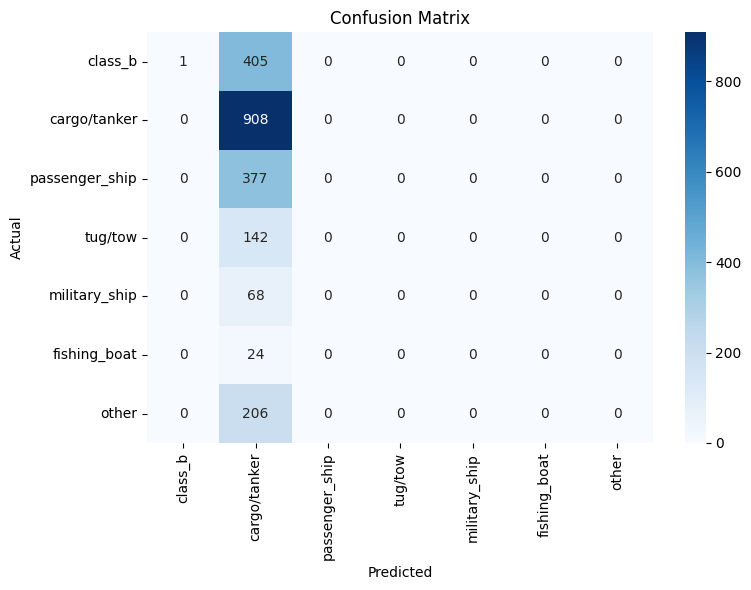

In [17]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from core.DICT import TYPE_to_LABEL 

# Assuming TYPE_to_LABEL is defined like:
# TYPE_to_LABEL = {'classA': 0, 'classB': 1, 'classC': 2}
LABEL_to_TYPE = {v: k for k, v in TYPE_to_LABEL.items()}
# Load checkpoint and model
checkpoint = torch.load('models/lstm_5_epochs.pth')

device = 'mps'

model = TypeLSTMClassifier(hidden_dim_lstm = HIDDEN_DIM_LSTM, hidden_dim_linear_1=HIDDEN_DIM_LINEAR_1, hidden_dim_linear_2=HIDDEN_DIM_LINEAR_2, num_layers=NUM_LAYERS_LSTM).to(device)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Run evaluation
all_preds = []
all_labels = []

with torch.inference_mode():
    progress_bar = tqdm(test_loader, desc="Running Test", leave=False)
    for x_test, lengths_test, summaries_test, y_test in progress_bar:
        x_test = x_test.to(device)
        summaries_test = summaries_test.to(device)
        
        logits = model(x_test, lengths_test, summaries_test)
        preds = torch.argmax(logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_test.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Decode labels to class names
all_preds_named = [LABEL_to_TYPE[p] for p in all_preds]
all_labels_named = [LABEL_to_TYPE[t] for t in all_labels]

# Accuracy and report
print("🔍 Test Accuracy:", accuracy_score(all_labels_named, all_preds_named))
print("\n📊 Classification Report:\n", classification_report(all_labels_named, all_preds_named))

# Confusion matrix
cm = confusion_matrix(all_labels_named, all_preds_named, labels=list(TYPE_to_LABEL.keys()))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=TYPE_to_LABEL.keys(),
            yticklabels=TYPE_to_LABEL.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


{0: 'class_b',
 1: 'cargo/tanker',
 2: 'passenger_ship',
 3: 'tug/tow',
 4: 'military_ship',
 5: 'pleasure_craft',
 6: 'fishing_boat',
 7: 'other'}